In [1]:
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns


Первоначальная идея состояла в выделении кластеров на основе признаков из аудиосообщений. На практике, все алгоритмы кластеризации требуют большое количество данных в кластере, что не подходит под бизнес задачу работы, ведь ни один человек не согласиться записывать по 350 голосовых сообщений, для добавления его голоса в базу данных. 

В основном, я использовал небольшую подвыборку из датасета, призванную симулировать реальные условия применения данной модели. Я решил действовать в рамках пяти голосовых сообщений на одного пользователя. Также пробовал по 350 объектов на один класс с малым количеством классов, что всё равно не смогло обеспечить достойного результата.

Все модели я логировал с помощью mlflow, что намного облегчило сравнение моделей в процессе их подбора

## Первый подход: обучение без учителя, кластеризация голосов

## Модели с заранее известным количеством кластеров, 102 класса, 5 аудиозаписей на каждый класс

In [2]:
experiment_name = "clusterization, 102 classes, 5 per class"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
clust_102_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
clust_102_5_df = clust_102_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]
clust_102_5_df = pd.melt(
    clust_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

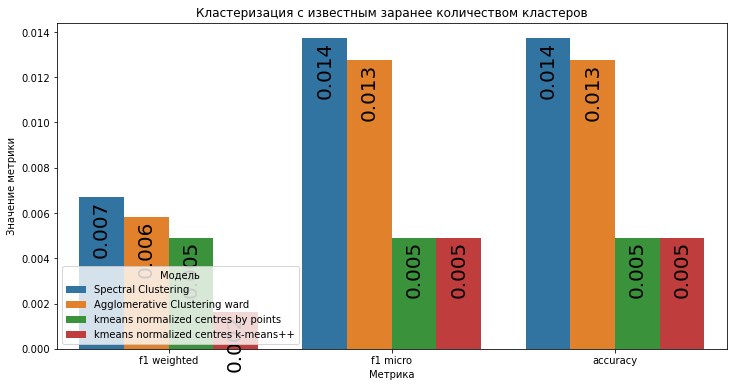

In [3]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value', hue='tags.mlflow.runName', data=clust_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
plt.legend(title='Модель', loc='lower left')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
bar.set_title('Кластеризация с известным заранее количеством кластеров')

KMeans с указанием начальных точек кластеров как одна из точек, принадлежащих этому классу имеет качетсво выше, вем у k-means++ инициализации, но всё равно очень низкое

Как видно, построенные модели имеют ужасное качество кластеризации. С неизвестным количеством кластеров дела состоят ещё хуже, а ещё число кластеров не совпадает с исходным числом в данных для обучения, из-за чего использование f1 метрики невозможно из-за съехавших меток классов. Здесь используется скорректированный индекс Rand как метрика.

## Модели с заранее неизвестным количеством кластеров

In [4]:
experiment_name = "clusterization without the number of classes, 102 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
clust_102_5_df = mlflow.search_runs(
    [experiment_id], order_by=['metrics.adjusted_rand_score']
)
clust_102_5_df = clust_102_5_df.iloc[::-1][
    ['tags.mlflow.runName', 'metrics.adjusted_rand_score']
]
clust_102_5_df = pd.melt(
    clust_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.adjusted_rand_score'],
    var_name='Metric',
    value_name='Value',
)

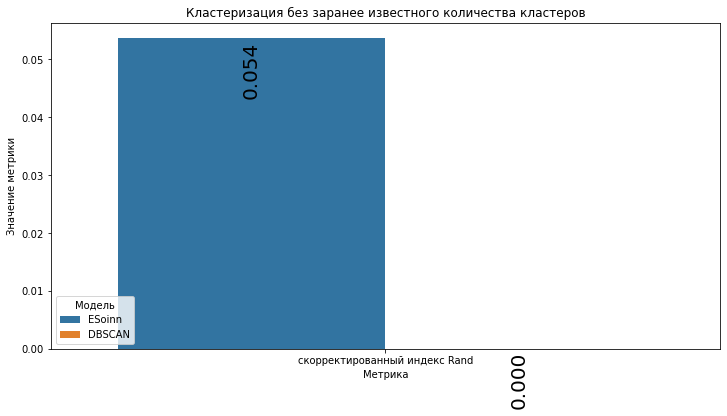

In [5]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value', hue='tags.mlflow.runName', data=clust_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['скорректированный индекс Rand'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
plt.legend(title='Модель', loc='lower left')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
bar.set_title('Кластеризация без заранее известного количества кластеров')

DBScan вообще не может выделить кластеры, а ESoinn хоть и выделяет чуть больше, чем 102 кластера, но они не соответсвуют исходным меткам в датасете

## Следующий подход: обучение с учителем, классификация голосов

В задачи классификации были выдвинуты те же ограничения, а именно 5 объектов каждого класса на обучающей выборке.

Было проверено большое количество моделей, параметры которых подбирались как с помощью поиска по сетке, так и с помощью библиотеки optuna для более тяжеловесных моделей

In [6]:
experiment_name = "only mfcc 102 classes"
experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
cls_102_5_df = mlflow.search_runs([experiment_id], order_by=['metrics.f1_weighted'])
cls_102_5_df = cls_102_5_df.iloc[::-1][
    [
        'tags.mlflow.runName',
        'metrics.f1_weighted',
        'metrics.f1_micro',
        'metrics.accuracy',
    ]
]
cls_102_5_df = pd.melt(
    cls_102_5_df,
    id_vars='tags.mlflow.runName',
    value_vars=['metrics.f1_weighted', 'metrics.f1_micro', 'metrics.accuracy'],
    var_name='Metric',
    value_name='Value',
)

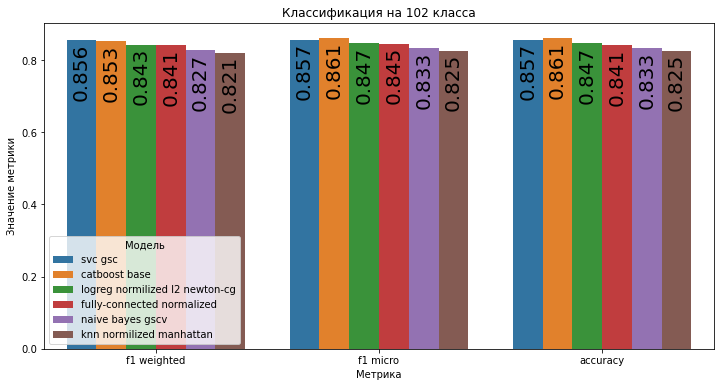

In [7]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Metric', y='Value', hue='tags.mlflow.runName', data=cls_102_5_df)
sns.move_legend(bar, loc='upper left')
bar.set_xticklabels(['f1 weighted', 'f1 micro', 'accuracy'])
bar.set_xlabel('Метрика')
bar.set_ylabel('Значение метрики')
for container in bar.containers:
    bar.bar_label(container, fmt='%.3f', rotation=90, padding=-60, size=20)
plt.legend(title='Модель', loc='lower left')
bar.set_title('Классификация на 102 класса')